In [1]:
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis

import healpy as hp
import pymaster as nmt

from power_spectra import *
c = cosmology()

In [32]:
data = np.load('subhalo_params004.npz')

k_grid = data['k_grid']
M_grid = data['M_grid']
z_grid = data['z_grid']

nk = len(k_grid) 
nM = len(M_grid)
nz = len(z_grid)

m_mz  = data['m_mz']
I_kmz = data['I_kmz']
J_kmz = data['J_kmz']

nk=len(k_grid)
nM=len(M_grid)
nz=len(z_grid)

kmin = k_grid.min()
kmax = k_grid.max()
print(f'kmin = {kmin:.2e} 1/Mpc, kmax = {kmax:.2e} 1/Mpc')

zmin = z_grid.min()
if zmin < 0.01:
    zmin = 0.01
zmax = z_grid.max()
print(f'zmin = {zmin:.2f}, zmax = {zmax:.2f}')

Mmin = M_grid.min()
Mmax = M_grid.max()
print(f'Mmin = {Mmin:.2e} Msun/h, Mmax = {Mmax:.2e} Msun/h')

kmin = 1.00e-05 1/Mpc, kmax = 1.00e+03 1/Mpc
zmin = 0.01, zmax = 2.00
Mmin = 1.00e+09 Msun/h, Mmax = 1.00e+17 Msun/h


In [61]:
ps_halomod = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=k_grid.max()-1e-8,Pmm_file = 'standard_halo_model_power_spectra005.npz',Pmm_field= "P_hh_total")

kmin = 1.001e-05, kmax = 1.000e+03, chimin = 4.437e+01, chimax = 5.312e+03, zmin = 0.010, zmax = 2.000
Loaded Pmm from file: standard_halo_model_power_spectra005.npz, field: P_hh_total


In [62]:
ps_sub = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=kmax-1e-8,Pmm_file = "halo_model_power_spectra_substructure005.npz",Pmm_field= "P_hh_total")

kmin = 1.001e-05, kmax = 1.000e+03, chimin = 4.437e+01, chimax = 5.312e+03, zmin = 0.010, zmax = 2.000
Loaded Pmm from file: halo_model_power_spectra_substructure005.npz, field: P_hh_total


In [5]:
ps_lin = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=kmax-1e-8)

kmin = 1.001e-05, kmax = 1.000e+03, chimin = 4.437e+01, chimax = 5.312e+03, zmin = 0.010, zmax = 2.000
Computed Pmm using Colossus


In [52]:
if k_grid.max() > 1e3:
    k_camb= np.logspace(np.log10(k_grid.min()),3,nk)
else:
    k_camb = k_grid

ps_camb = power_spectrum(zmin=zmin, zmax=zmax,kmin=k_camb.min()+1e-8,kmax=k_camb.max()-1e-8,use_camb=True,nonlin_model="mead2020")
logP_interp_camb = ps_camb.get_logPmm_interp()

kmin = 1.001e-05, kmax = 1.000e+03, chimin = 4.437e+01, chimax = 5.312e+03, zmin = 0.010, zmax = 2.000
Note: redshifts have been re-sorted (earliest first)
Computed Pmm using CAMB


In [7]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

hdudes = fits.open('data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits')

data_source = hdudes['nz_source'].data[:-1]
data_lens = hdudes['nz_lens'].data[:-1]

header_source = hdudes['nz_source'].header
header_lens = hdudes['nz_lens'].header

In [8]:
#redshift bins Redmagic
z_lims = np.array([0.15,0.35,0.5,0.65,0.8,0.9])

bin_number_source = 4
zs = np.array(data_source['Z_MID'])
zs_bins = []
zs_means = []
nz_source_dict = {}
ngal_source_dict = {}
sige_source_dict = {}
for i in range(bin_number_source):
    z = zs[(zs >= z_lims[i]) & (zs < z_lims[i+1])]
    zs_bins.append(np.array(z))
    zs_means.append(np.mean(z))
    nz_source_dict[i] = data_source['BIN' + str(i+1)]
    ngal_source_dict[i] = header_source['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str
    sige_source_dict[i] = header_source['SIG_E_' + str(i+1)]


bin_number_lens = 5
zl = np.array(data_lens['Z_MID'])
zl_bins = []
zl_means = []
nz_lens_dict = {}
ngal_lens_dict = {}
for i in range(bin_number_lens):
    z = zl[(zl >= z_lims[i]) & (zl < z_lims[i+1])]
    zl_bins.append(np.array(z))
    zl_means.append(np.mean(z))
    nz_lens_dict[i] = data_lens['BIN' + str(i+1)]
    ngal_lens_dict[i] = header_lens['NGAL_' + str(i+1)] * (60 * 180 / np.pi)**2 # gal/arcmin^2  -> gal/str



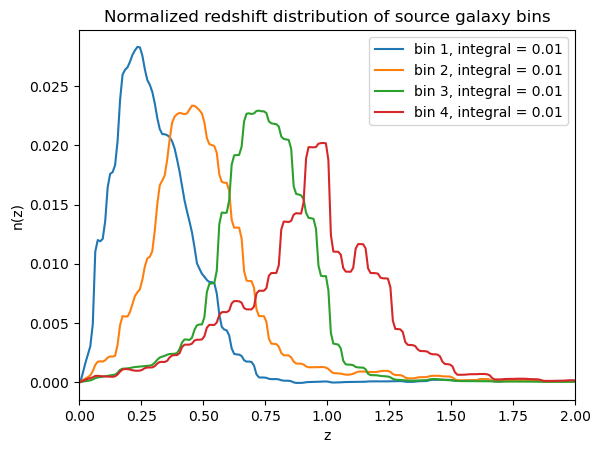

In [11]:
for i in range(4):
    n_int = np.trapezoid(nz_source_dict[i], zs)
    plt.plot(zs,nz_source_dict[i],label=f'bin {i+1}, integral = {n_int:.2f}')
    plt.xlim(0,2)
    plt.title('Normalized redshift distribution of source galaxy bins')
    plt.xlabel('z')
    plt.ylabel('n(z)')
    plt.legend()

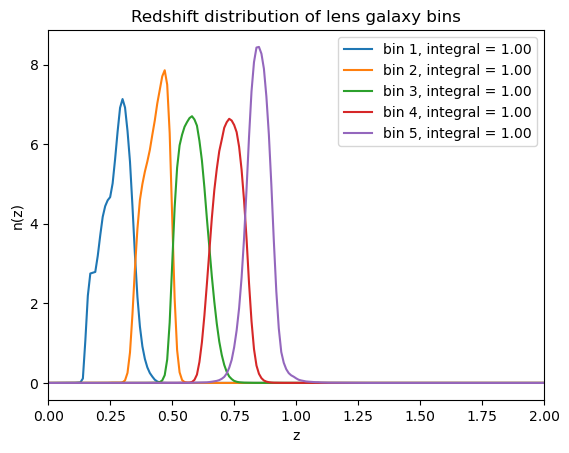

In [12]:
for i in range(5):
    n_int = np.trapezoid(nz_lens_dict[i], zl)
    plt.plot(zl,nz_lens_dict[i],label=f'bin {i+1}, integral = {n_int:.2f}')
    plt.xlim(0,2)
    plt.title('Redshift distribution of lens galaxy bins')
    plt.xlabel('z')
    plt.ylabel('n(z)')
    plt.legend()

In [9]:
#Biases REDMAGIC
galaxy_bias = np.array([1.7, 1.7, 1.7, 2.0, 2.0])  # lens galaxy bias for each lens bin
magnification_bias = np.array([1.3134, -0.5179, 0.3372, 2.2515, 1.9667])  # magnification bias for each lens bin
shear_calibration_bias = np.array([-0.0063,-0.0198,-0.0241,-0.0369])  # shear calibration bias for each source bin

#redshift shift for lens galaxsssies REDMAGIC
shift_params = np.array([0.006,0.001,0.004,-0.002,-0.007])
stretch_params = np.array([1,1,1,1,1.23])

#Intrinsic Alignment (IA)
IA_params = np.array([0.7,-1.36,-1.7,-2.5,1.0,0.62]) #a1,a2,alf1,alfa2,bTA,z0
C1_mean=5e-14 # h^2 Msun^-1 Mpc^3

In [10]:
ells = np.loadtxt("data/ang_sqrt.txt")
print("len(ells):",len(ells))

len(ells): 32


In [15]:
# l bins are integers but close to the 
lmin = 8
lmax = 2048
n_bins = 32
nside = 1024

# Generate sqrt-spaced edges
sqrt_edges = np.linspace(np.sqrt(lmin), np.sqrt(lmax), n_bins + 1)
edges = sqrt_edges**2
edges = np.round(edges).astype(int)
edges[-1] = lmax + 1

# Create NaMaster binning object
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
ells_binned = b.get_effective_ells()

In [41]:
# l bins are integers but close to the 
lmin = 0
lmax = 2048

print(f"lmin: {lmin}")
print(f"lmax: {lmax}")
print("\n")

ells = np.arange(lmax + 1) 
print("len(ells):",len(ells))

lmin: 0
lmax: 2048


len(ells): 2049


In [42]:
print(f"kmin subhalo data: {kmin:.3e}")
print(f"kmax subhalo data: {kmax:.3e}")

print(f"kmin necessary: {(ells.min() + 0.5 )/ ps_camb.chi[-1]:.3e}")
print(f"kmax necessary: {(ells.max() + 0.5 )/ ps_camb.chi[0]:.3e}")

kmin subhalo data: 1.000e-05
kmax subhalo data: 1.000e+03
kmin necessary: 9.413e-05
kmax necessary: 4.616e+01


In [67]:
ps=ps_halomod
name = 'halo'

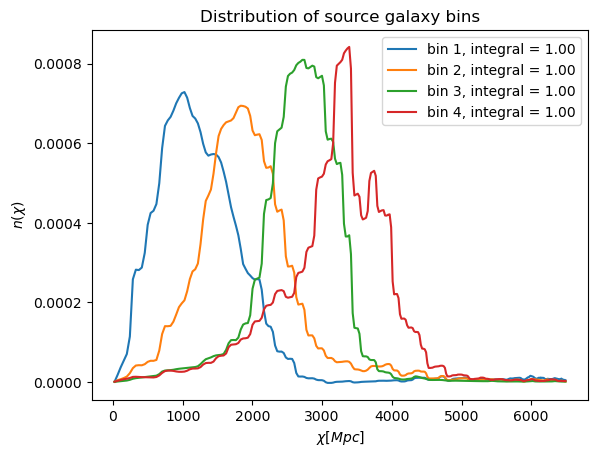

In [11]:
chi = ps.comoving_distance(zs)
for i in range(4):
    nchi_interp = ps.nz_to_nchi_interp(nz_source_dict[i], zs)
    n_int = np.trapezoid(nchi_interp(chi), chi)
    plt.plot(chi,nchi_interp(chi),label=f'bin {i+1}, integral = {n_int:.2f}')
    plt.title('Distribution of source galaxy bins')
    plt.xlabel(r'$\chi [Mpc]$')
    plt.ylabel(r'$n(\chi)$')
    plt.legend()

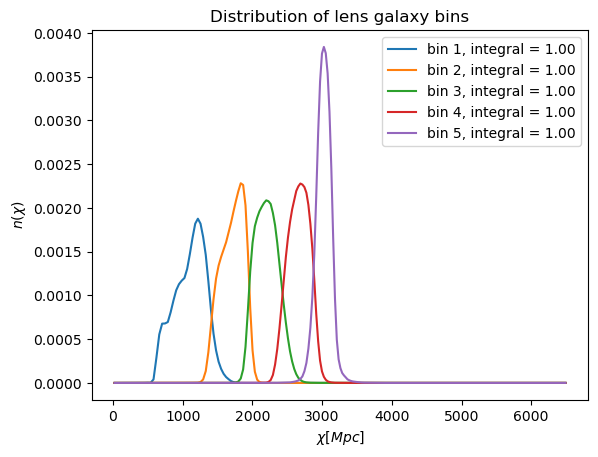

In [24]:
for i in range(5):
    nchi_interp = ps.nz_to_nchi_interp(nz_lens_dict[i], zl,z_mean=zl_means[i],shift = shift_params[i], stretch = stretch_params[i])
    n_int = np.trapezoid(nchi_interp(chi), chi)    
    plt.plot(chi,nchi_interp(chi),label=f'bin {i+1}, integral = {n_int:.2f}')
    plt.title('Distribution of lens galaxy bins')
    plt.xlabel(r'$\chi [Mpc]$')
    plt.ylabel(r'$n(\chi)$')
    plt.legend()

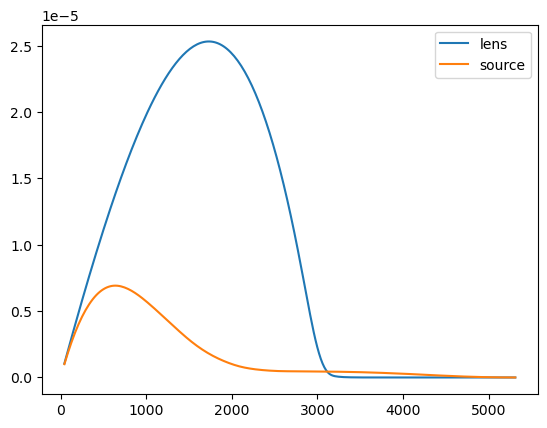

In [13]:
i=4
j=0
plt.plot(ps.chi,ps.lensing_efficiency(nchi_interp = ps.nz_to_nchi_interp(nz_lens_dict[i], zl,z_mean=zl_means[i],shift = shift_params[i], stretch = stretch_params[i]),shear=0),label="lens")
plt.plot(ps.chi,ps.lensing_efficiency(nchi_interp = ps.nz_to_nchi_interp(nz_source_dict[j], zs),shear=shear_calibration_bias[j]),label="source")
plt.legend()

In [68]:
cls_gk = np.zeros((5,4,len(ells)))
cls_gI = np.zeros((5,4,len(ells)))
cls_mag_I = np.zeros((5,4,len(ells)))
cls_mag_k = np.zeros((5,4,len(ells)))
cls_gg = np.zeros((5,4,len(ells)))
cls_kk = np.zeros((5,4,len(ells)))           
#i for lens, j for source
for i in range(5):
    for j in range(4):
            nz_source = nz_source_dict[j]
            shear = shear_calibration_bias[j] if shear_calibration_bias is not None else 0

            nz_lens = nz_lens_dict[i]   
            zl_mean = zl_means[i]         
            shift_lens = shift_params[i] if shift_params is not None else 0
            stretch_lens = stretch_params[i] if stretch_params is not None else 1
            gb = galaxy_bias[i]
            mb = magnification_bias[i]

            NLA = True

            cls_gk[i,j,:] = ps.cls_gk(l_bins=ells, galaxy_bias=gb, zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens,shear=shear)
            cls_gI[i,j,:] = ps.cls_gI(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch = stretch_lens,  nz_lens_shift = shift_lens,NLA=NLA)
            cls_mag_I[i,j,:] = ps.cls_mag_I(l_bins=ells,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean,magnification_bias=mb, nz_lens_stretch = stretch_lens,  nz_lens_shift = shift_lens,NLA=NLA)
            cls_mag_k[i,j,:] = ps.cls_mag_k(l_bins=ells,galaxy_bias=gb,zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean,magnification_bias=mb,nz_lens_stretch = stretch_lens,  nz_lens_shift = shift_lens, shear=shear)
            cls_kk[i,j,:] = ps.cls_kk(l_bins=ells, zs=zs, nz_source=nz_source, shear=shear)
            cls_gg[i,j,:] = ps.cls_gg(l_bins=ells, galaxy_bias=gb, zl=zl, nz_lens=nz_lens, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens)

In [69]:
np.savez('Cls_'+name+'.npz', cls_gk=cls_gk, cls_gI=cls_gI, cls_mag_I=cls_mag_I, cls_mag_k=cls_mag_k, cls_gg=cls_gg, cls_kk=cls_kk,ells = ells)

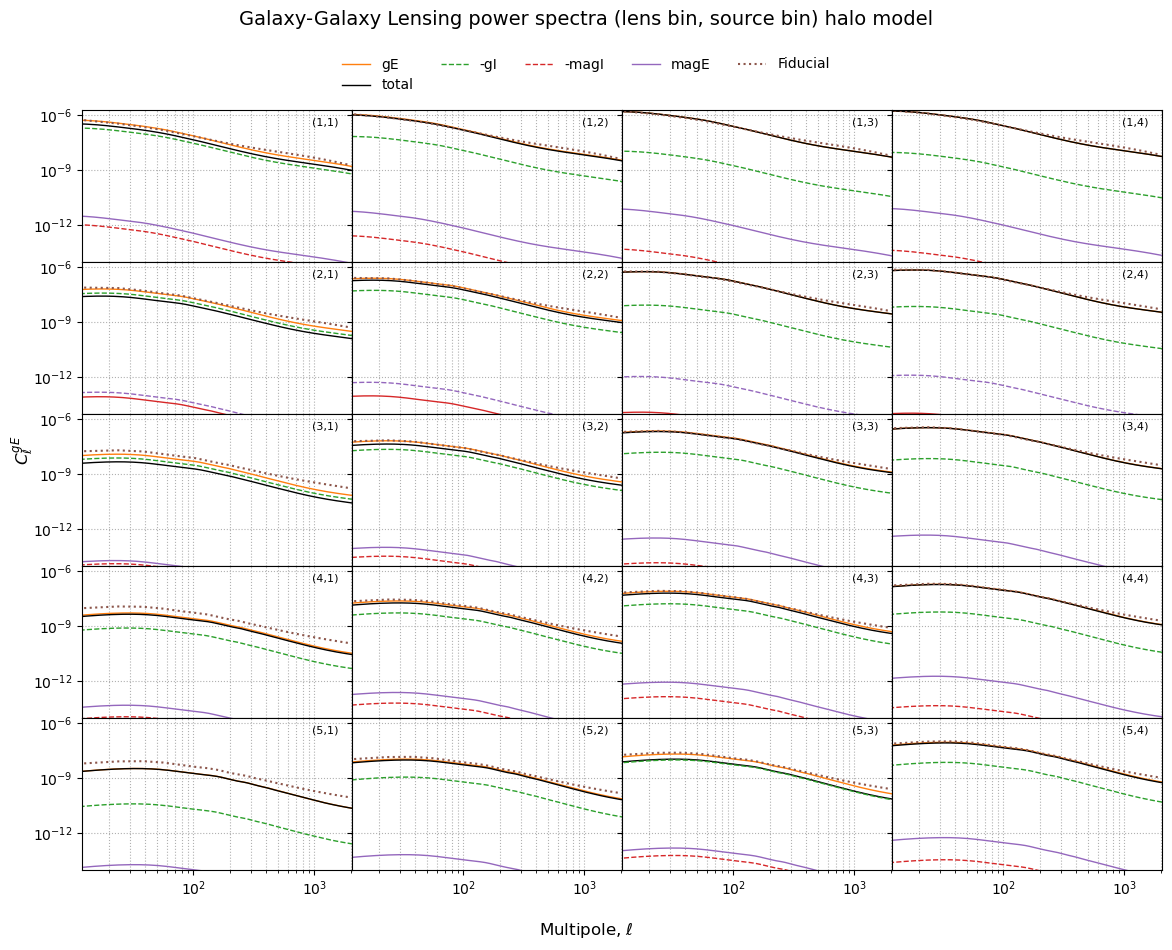

In [70]:
n_lens, n_source = 5, 4

from matplotlib.ticker import LogLocator

fig, axes = plt.subplots(
    n_lens, n_source,
    figsize=(12, 10),
    sharex=True,
    sharey=True
)

for i in range(n_lens):
    for j in range(n_source):

        ax = axes[i, j]

        # Main spectra
        ax.plot(ells, cls_gk[i, j, :], color='C1', lw=1, label='gE')
        ax.plot(ells, cls_gk[i, j, :]+cls_mag_I[i, j, :]+cls_mag_k[i, j, :]+cls_gI[i, j, :], color='black', lw=1, label='total')

        if np.all(cls_gI[i, j, :] < 0):
            ax.plot(ells, -cls_gI[i, j, :], linestyle='--',color='C2', lw=1, label='-gI')
        else:
            ax.plot(ells, cls_gI[i, j, :], linestyle='-',color='C2', lw=1, label='gI')

        if np.all(cls_mag_I[i, j, :] < 0):
            ax.plot(ells, -cls_mag_I[i, j, :], linestyle='--',color='C3', lw=1, label='-magI')
        else:
            ax.plot(ells, cls_mag_I[i, j, :], linestyle='-',color='C3', lw=1, label='magI')

        if np.all(cls_mag_k[i, j, :] < 0):
            ax.plot(ells, -cls_mag_k[i, j, :], linestyle='--',color='C4', lw=1, label='-magE')
        else:
            ax.plot(ells, cls_mag_k[i, j, :], linestyle='-',color='C4', lw=1, label='magE')

        cl_fid = np.array([cls_fid['VALUE'][x] for x in range(len(cls_fid)) if cls_fid['BIN1'][x]==i+1 and cls_fid['BIN2'][x]==j+1])
        l_bins_fid = np.array([cls_fid['ANG'][x] for x in range(len(cls_fid)) if cls_fid['BIN1'][x]==i+1 and cls_fid['BIN2'][x]==j+1])
        ax.plot(l_bins_fid, cl_fid,color='C5', linestyle=':', label='Fiducial')



        # Bin label
        ax.text(
            0.95, 0.95, f"({i+1},{j+1})",
            transform=ax.transAxes,
            ha="right", va="top", fontsize=8
        )

        ax.set_xscale("log")
        ax.set_yscale("log")

        ax.set_xlim(12,ells.max())
        ax.set_ylim(9e-15,2e-6)

        # Grid (shared visually because axes are shared)
        ax.grid(True, which="both", ls=":")

        ax.yaxis.set_major_locator(LogLocator(numticks=4))
        ax.xaxis.set_major_locator(LogLocator(numticks=3))


# Shared axis labels
fig.supxlabel(r"Multipole, $\ell$", fontsize=12)
fig.supylabel(r"$C_{\ell}^{gE}$", fontsize=12)

fig.suptitle(
    'Galaxy-Galaxy Lensing power spectra (lens bin, source bin) '+name+' model',
    fontsize=14,
    y=0.94
)

handles, labels = axes[0, 0].get_legend_handles_labels()

fig.legend(
    handles, labels,
    loc='upper center',
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, 0.905)  # <-- just beneath the suptitle
)


plt.subplots_adjust(
    wspace=0.0, hspace=0.0,
    top=0.84,   # lowered to make room for legend
    bottom=0.08,
    left=0.08,
    right=0.98
)

plt.show()